In [1]:
import os
import tensorflow as tf
import glob
import pathlib
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense,Conv2D,Flatten

In [2]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
root = '/content/drive/MyDrive/Education/Data Science/6. Deep Learning/data'

In [5]:
train_dir = root + '/train'
validation_dir = root + '/valid'
test_dir = root + '/test'

In [6]:
counts = pd.read_pickle(root + '/counts')

Import the species data from the previous notebook as well as the functions needed to assemble into a format amenable to CNNs. Functions are in hidden cells below.

In [7]:
#@title

# Based on https://stackoverflow.com/questions/60448904/use-only-n-images-using-imagedatagenerator-from-each-class but for number of species

# This function lets us loop through the data until we reach the desired number of classes for the classes with the highest number of training images
def get_data(data_dir, species, n=5):
  species = list(species.index)[:n]
  a=[]
  for i, directory in enumerate(os.listdir(data_dir)):
    if directory[0] != '.' and directory in species:
        for bird in os.listdir(data_dir+'/'+directory):
            a.append((f'{data_dir}/{directory}/{bird}',directory))
        if i == n - 1: return pd.DataFrame(a,columns=['filename','class'])
    else: n += 1

In [8]:
#@title

# Looping through the training data will collect different species than looping through the valid and test data so we need a function that will collect the proper valid/test data
def get_valid_test_data(df, data_dir):
  a = []
  classes = df['class'].unique()
  for class_ in classes:
    if class_[0] != '.':
      directory =  data_dir + '/' + class_
      for species in os.listdir(directory):
        a.append((f'{directory}/{species}',class_))
  return pd.DataFrame(a, columns=['filename','class'])

Start with two species and scale up if it works.

In [9]:
train_data = get_data(train_dir, counts, 2)
valid_data = get_valid_test_data(train_data, validation_dir)
test_data = get_valid_test_data(train_data, test_dir)

In [10]:
train_data

,filename,class
0,/content/drive/MyDrive/Education/Data Science/...,D-ARNAUDS BARBET
1,/content/drive/MyDrive/Education/Data Science/...,D-ARNAUDS BARBET
2,/content/drive/MyDrive/Education/Data Science/...,D-ARNAUDS BARBET
3,/content/drive/MyDrive/Education/Data Science/...,D-ARNAUDS BARBET
4,/content/drive/MyDrive/Education/Data Science/...,D-ARNAUDS BARBET
...,...,...
477,/content/drive/MyDrive/Education/Data Science/...,HOUSE FINCH
478,/content/drive/MyDrive/Education/Data Science/...,HOUSE FINCH
479,/content/drive/MyDrive/Education/Data Science/...,HOUSE FINCH
480,/content/drive/MyDrive/Education/Data Science/...,HOUSE FINCH


In [11]:
def create_model():

  vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
  #eff_model.summary()
  vgg_model.trainable = False

  layer0 = tf.keras.layers.Flatten(name='flatten')(vgg_model.output)
  layer1 = tf.keras.layers.Dense(4096, activation='relu',name='fc1')(layer0)
  layer2 = tf.keras.layers.Dense(4096, activation='relu',name='fc2')(layer1)

In [13]:
# https://www.kaggle.com/code/yaswanthgali/using-resnet-transfer-learning

def run_model(**params):

  # collect data
  train_data = get_data(train_dir, counts, params['num_species'])
  valid_data = get_valid_test_data(train_data, validation_dir)
  test_data = get_valid_test_data(train_data, test_dir)

  # create data generators to including augmentation
  # https://github.com/caroshi/neuralnetworks_art-periods-classification/blob/master/modeling/threeclass--cnn.ipynb
  train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input, horizontal_flip=params['horizontal_flip'], rotation_range=params['rotation_range'],)# rescale=1./255)
  val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input, horizontal_flip=params['horizontal_flip'], rotation_range=params['rotation_range'],)# rescale=1./255)

  train_generator = train_datagen.flow_from_dataframe(
          train_data,
          directory = None,
          x_col = 'filename',
          y_col = 'class',
          target_size=(224, 224),
          batch_size=params['train_batch_size'],
          class_mode='categorical')

  validation_generator = val_datagen.flow_from_dataframe(
          valid_data,
          directory = None,
          x_col = 'filename',
          y_col = 'class',
          target_size=(224, 224),
          batch_size=params['valid_batch_size'],
          class_mode='categorical')
  
  # Create a prefit model
  # https://www.kaggle.com/code/taninudomthanakij/beginner-with-vgg16-97-79

  pretrained_model = ResNet50(
      input_shape=(224,224, 3),
      include_top=False,
      weights='imagenet',
      pooling='avg'
  )
  pretrained_model.trainable = False

  inputs = pretrained_model.input

  x = Dense(120, activation='relu')(pretrained_model.output)
  x = Dense(120, activation='relu')(x)#adding some custom layers of our coice

  outputs = Dense(train_data['class'].nunique(), activation='softmax')(x)
  #output choice
  model = Model(inputs=inputs, outputs=outputs)


  # Set optimizer and compile

  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  mo_fit=model.fit(train_generator, validation_data=validation_generator, epochs=params['num_epochs'])


  
  acc = mo_fit.history['accuracy']
  val_acc = mo_fit.history['val_accuracy']
  loss = mo_fit.history['loss']
  val_loss = mo_fit.history['val_loss']

  epochs = range(len(acc))

  plt.figure(figsize=(10,7))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.gca().set_ylim([0,1])
  plt.title('Training and validation accuracy', fontsize=18)
  plt.xlabel('Number of epochs', fontsize=14)
  plt.ylabel('Accuracy', fontsize=14)  
  plt.legend(loc=0)


  plt.show()



  # plt.figure(figsize=(10,7))
  # plt.plot(epochs, acc, 'bo', label='Training acc')
  # plt.plot(epochs, val_acc, 'b', label='Validation acc')
  # plt.title('Training and validation accuracy', fontsize=18)
  # plt.xlabel('Number of epochs', fontsize=14)
  # plt.ylabel('Accuracy', fontsize=14)
  # plt.legend()

  plt.figure(figsize=(10,7))
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.gca().set_ylim([0,1])
  plt.title('Training and validation loss', fontsize=18)
  plt.xlabel('Number of epochs', fontsize=14)
  plt.ylabel('Loss', fontsize=14)
  plt.legend()

  plt.show()

In [13]:
params = {}
params['num_species'] = 2
params['num_epochs'] = 6
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['learning_rate'] = 0.0001
# params['model'] = create_model()
params['horizontal_flip'] = False
params['rotation_range'] = False # set between 0 and 45 degrees

Found 482 validated image filenames belonging to 2 classes.
Found 10 validated image filenames belonging to 2 classes.
94781440/94765736 [==============================] - 2s 0us/step
Epoch 1/6
17/17 [==============================] - 156s 9s/step - loss: 0.2022 - accuracy: 0.9066 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 2/6
17/17 [==============================] - 3s 151ms/step - loss: 0.0230 - accuracy: 0.9938 - val_loss: 2.3223e-04 - val_accuracy: 1.0000
Epoch 3/6
17/17 [==============================] - 3s 151ms/step - loss: 0.0203 - accuracy: 0.9959 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 4/6
17/17 [==============================] - 3s 149ms/step - loss: 0.0068 - accuracy: 0.9979 - val_loss: 5.6365e-05 - val_accuracy: 1.0000
Epoch 5/6
17/17 [==============================] - 3s 150ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 4.7938e-05 - val_accuracy: 1.0000
Epoch 6/6
17/17 [==============================] - 3s 151ms/step - loss: 2.8914e-04 - accuracy: 1.00

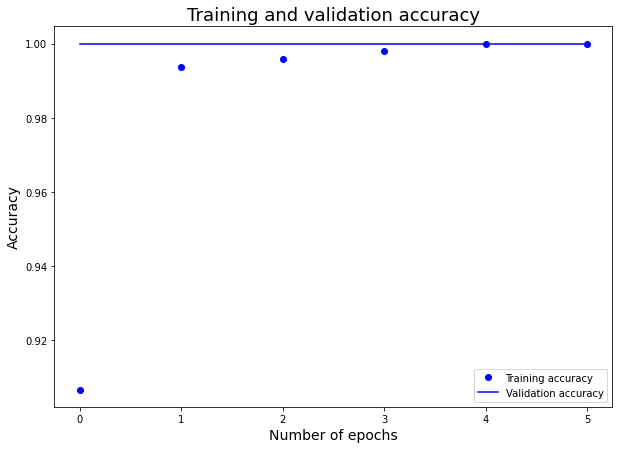

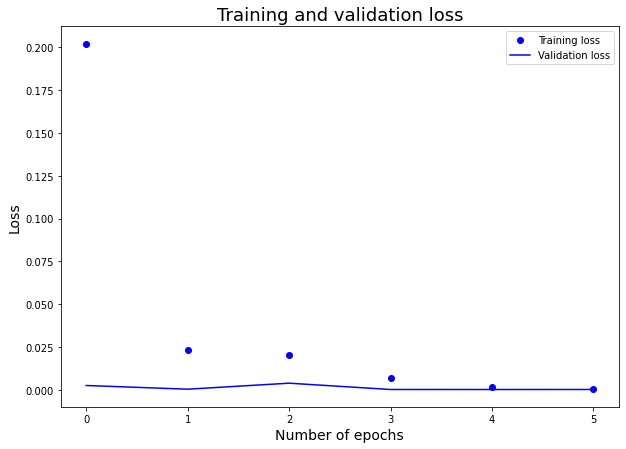

In [14]:
run_model(**params)

ResNet was very successful with 2 classes so let's try 20.

In [15]:
params = {}
params['num_species'] = 20
params['num_epochs'] = 5
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['learning_rate'] = 0.0001
# params['model'] = create_model()
params['horizontal_flip'] = False
params['rotation_range'] = False # set between 0 and 45 degrees

Found 4123 validated image filenames belonging to 20 classes.
Found 100 validated image filenames belonging to 20 classes.
Epoch 1/5
138/138 [==============================] - 2244s 16s/step - loss: 0.4310 - accuracy: 0.9001 - val_loss: 0.0239 - val_accuracy: 1.0000
Epoch 2/5
138/138 [==============================] - 21s 152ms/step - loss: 0.0531 - accuracy: 0.9867 - val_loss: 0.0317 - val_accuracy: 0.9900
Epoch 3/5
138/138 [==============================] - 21s 151ms/step - loss: 0.0161 - accuracy: 0.9968 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 4/5
138/138 [==============================] - 21s 153ms/step - loss: 0.0046 - accuracy: 0.9998 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 5/5
138/138 [==============================] - 21s 151ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0015 - val_accuracy: 1.0000


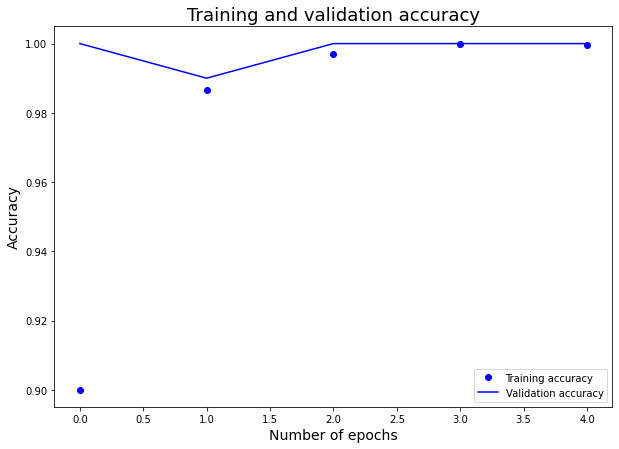

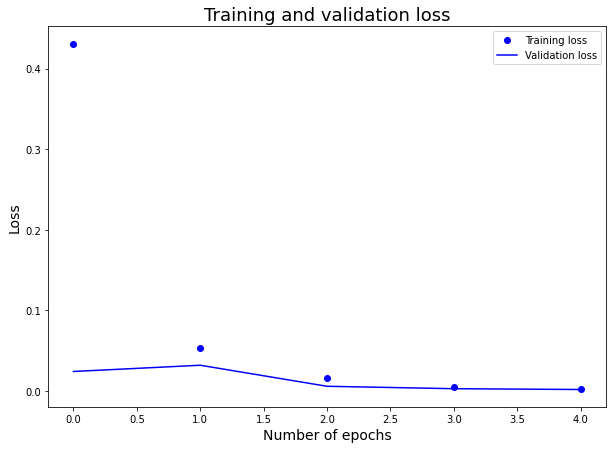

In [16]:
run_model(**params)

In [17]:
params = {}
params['num_species'] = 50
params['num_epochs'] = 5
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['learning_rate'] = 0.001
# params['model'] = create_model()
params['horizontal_flip'] = False
params['rotation_range'] = False # set between 0 and 45 degrees

Found 9458 validated image filenames belonging to 50 classes.
Found 250 validated image filenames belonging to 50 classes.
Epoch 1/5
316/316 [==============================] - 3561s 11s/step - loss: 0.7815 - accuracy: 0.8095 - val_loss: 0.1217 - val_accuracy: 0.9720
Epoch 2/5
316/316 [==============================] - 48s 151ms/step - loss: 0.1163 - accuracy: 0.9702 - val_loss: 0.0879 - val_accuracy: 0.9720
Epoch 3/5
316/316 [==============================] - 48s 150ms/step - loss: 0.0601 - accuracy: 0.9848 - val_loss: 0.0692 - val_accuracy: 0.9840
Epoch 4/5
316/316 [==============================] - 48s 151ms/step - loss: 0.0355 - accuracy: 0.9900 - val_loss: 0.0561 - val_accuracy: 0.9800
Epoch 5/5
316/316 [==============================] - 48s 150ms/step - loss: 0.0236 - accuracy: 0.9938 - val_loss: 0.0610 - val_accuracy: 0.9880


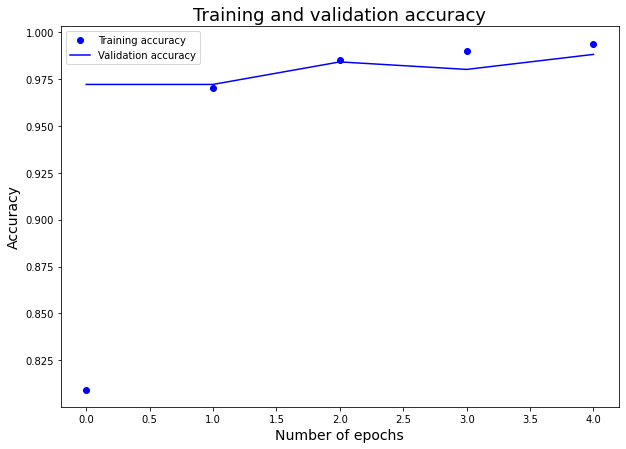

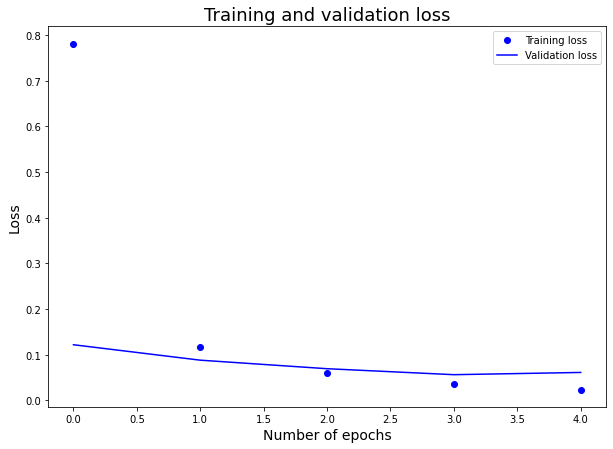

In [18]:
run_model(**params)

In [ ]:
params = {}
params['num_species'] = 20
params['num_epochs'] = 5
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['learning_rate'] = 0.0001
# params['model'] = create_model()
params['horizontal_flip'] = False
params['rotation_range'] = False # set between 0 and 45 degrees

Found 4123 validated image filenames belonging to 20 classes.
Found 100 validated image filenames belonging to 20 classes.
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
  

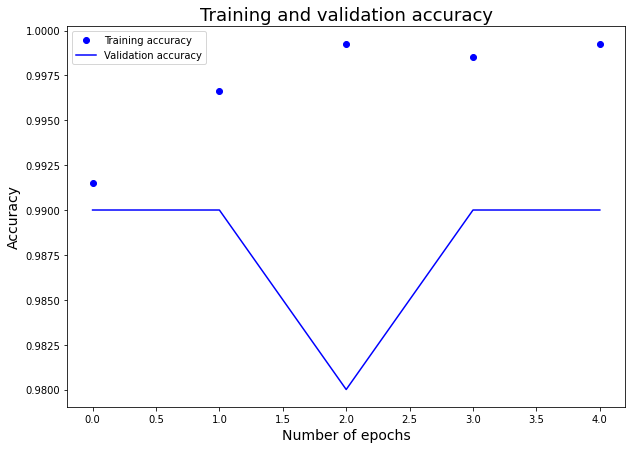

In [ ]:
run_model(**params)

In [ ]:
params = {}
params['num_species'] = 50
params['num_epochs'] = 5
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['learning_rate'] = 0.0001
# params['model'] = create_model()
params['horizontal_flip'] = False
params['rotation_range'] = False # set between 0 and 45 degrees

Found 9458 validated image filenames belonging to 50 classes.
Found 250 validated image filenames belonging to 50 classes.
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
  

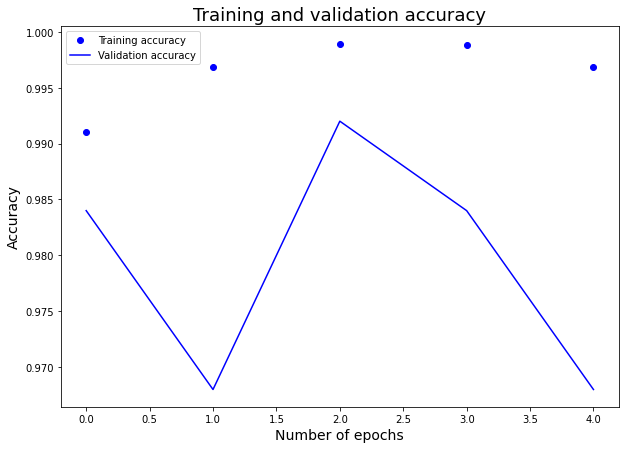

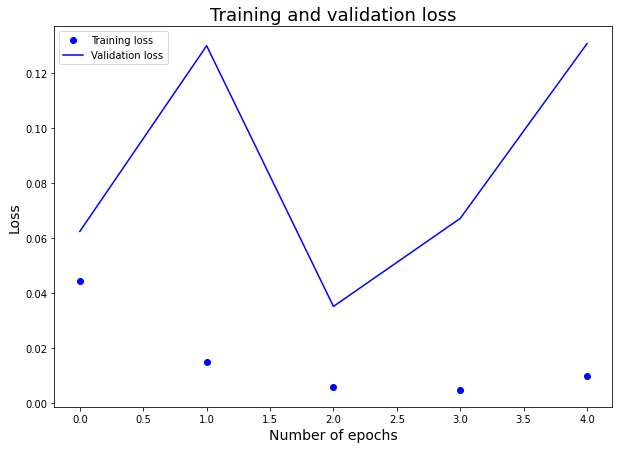

In [ ]:
run_model(**params)

Memory error with 100 classes. Further processing will need Google Colab Pro. Let's try turning on scaling so that t

In [14]:
params = {}
params['num_species'] = 50
params['num_epochs'] = 5
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['learning_rate'] = 0.0001
# params['model'] = create_model()
params['horizontal_flip'] = False
params['rotation_range'] = False # set between 0 and 45 degrees

Found 9458 validated image filenames belonging to 50 classes.
Found 250 validated image filenames belonging to 50 classes.
94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/5
316/316 [==============================] - 3160s 10s/step - loss: 0.7737 - accuracy: 0.8115 - val_loss: 0.1097 - val_accuracy: 0.9720
Epoch 2/5
316/316 [==============================] - 47s 148ms/step - loss: 0.1321 - accuracy: 0.9635 - val_loss: 0.0711 - val_accuracy: 0.9840
Epoch 3/5
316/316 [==============================] - 47s 147ms/step - loss: 0.0556 - accuracy: 0.9860 - val_loss: 0.0245 - val_accuracy: 1.0000
Epoch 4/5
316/316 [==============================] - 47s 148ms/step - loss: 0.0326 - accuracy: 0.9924 - val_loss: 0.0441 - val_accuracy: 0.9840
Epoch 5/5
316/316 [==============================] - 47s 148ms/step - loss: 0.0218 - accuracy: 0.9948 - val_loss: 0.1030 - val_accuracy: 0.9640


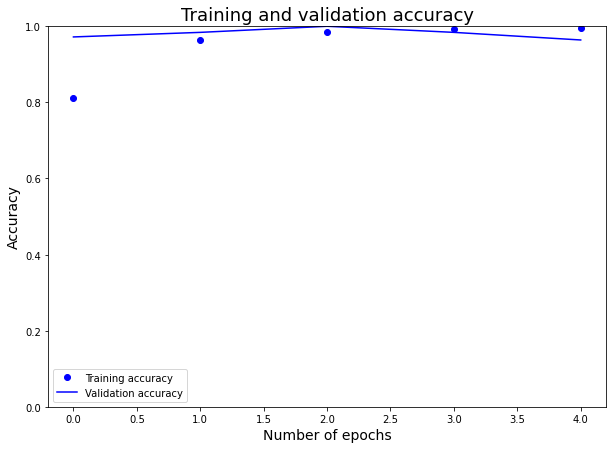

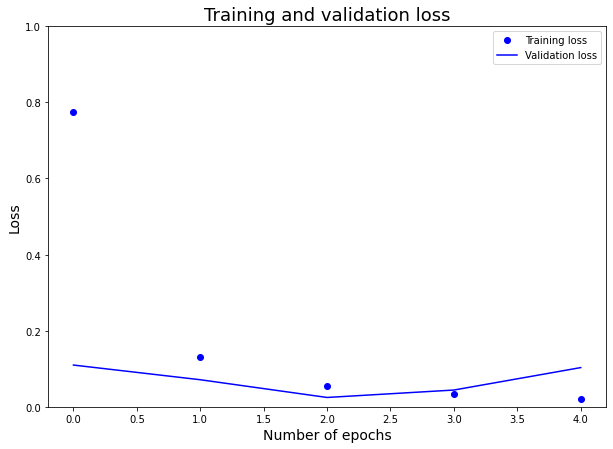

In [15]:
run_model(**params)

Due to memory constraints, we will use a gradient accumulation optimizer shown in the hidden cell below.

In [ ]:
#@title
# https://towardsdatascience.com/gradient-accumulation-overcoming-memory-constraints-in-deep-learning-36d411252d01

class AdamAccumulate(Optimizer):

  def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                epsilon=None, decay=0., amsgrad=False, accum_iters=1, **kwargs):
      if accum_iters < 1:
          raise ValueError('accum_iters must be >= 1')
      super(AdamAccumulate, self).__init__(**kwargs)
      with K.name_scope(self.__class__.__name__):
          self.iterations = K.variable(0, dtype='int64', name='iterations')
          self.lr = K.variable(lr, name='lr')
          self.beta_1 = K.variable(beta_1, name='beta_1')
          self.beta_2 = K.variable(beta_2, name='beta_2')
          self.decay = K.variable(decay, name='decay')
      if epsilon is None:
          epsilon = K.epsilon()
      self.epsilon = epsilon
      self.initial_decay = decay
      self.amsgrad = amsgrad
      self.accum_iters = K.variable(accum_iters, K.dtype(self.iterations))
      self.accum_iters_float = K.cast(self.accum_iters, K.floatx())

  # @interfaces.legacy_get_updates_support
  def get_updates(self, loss, params):
      grads = self.get_gradients(loss, params)
      self.updates = [K.update_add(self.iterations, 1)]

      lr = self.lr

      completed_updates = K.cast(K.tf.floordiv(self.iterations, self.accum_iters), K.floatx())

      if self.initial_decay > 0:
          lr = lr * (1. / (1. + self.decay * completed_updates))

      t = completed_updates + 1

      lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) / (1. - K.pow(self.beta_1, t)))

      # self.iterations incremented after processing a batch
      # batch:              1 2 3 4 5 6 7 8 9
      # self.iterations:    0 1 2 3 4 5 6 7 8
      # update_switch = 1:        x       x    (if accum_iters=4)  
      update_switch = K.equal((self.iterations + 1) % self.accum_iters, 0)
      update_switch = K.cast(update_switch, K.floatx())

      ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
      vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
      gs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]

      if self.amsgrad:
          vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
      else:
          vhats = [K.zeros(1) for _ in params]

      self.weights = [self.iterations] + ms + vs + vhats

      for p, g, m, v, vhat, tg in zip(params, grads, ms, vs, vhats, gs):

          sum_grad = tg + g
          avg_grad = sum_grad / self.accum_iters_float

          m_t = (self.beta_1 * m) + (1. - self.beta_1) * avg_grad
          v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(avg_grad)

          if self.amsgrad:
              vhat_t = K.maximum(vhat, v_t)
              p_t = p - lr_t * m_t / (K.sqrt(vhat_t) + self.epsilon)
              self.updates.append(K.update(vhat, (1 - update_switch) * vhat + update_switch * vhat_t))
          else:
              p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

          self.updates.append(K.update(m, (1 - update_switch) * m + update_switch * m_t))
          self.updates.append(K.update(v, (1 - update_switch) * v + update_switch * v_t))
          self.updates.append(K.update(tg, (1 - update_switch) * sum_grad))
          new_p = p_t

          # Apply constraints.
          if getattr(p, 'constraint', None) is not None:
              new_p = p.constraint(new_p)

          self.updates.append(K.update(p, (1 - update_switch) * p + update_switch * new_p))
      return self.updates

  def get_config(self):
      config = {'lr': float(K.get_value(self.lr)),
                'beta_1': float(K.get_value(self.beta_1)),
                'beta_2': float(K.get_value(self.beta_2)),
                'decay': float(K.get_value(self.decay)),
                'epsilon': self.epsilon,
                'amsgrad': self.amsgrad}
      base_config = super(AdamAccumulate, self).get_config()
      return dict(list(base_config.items()) + list(config.items()))

In [ ]:
        
# to be used in the following way

opt = AdamAccumulate(lr=0.001, decay=1e-5, accum_iters=5)
model.compile( loss='categorical_crossentropy',   # Loss function
                            optimizer=opt,        # Optimization technique
                            metrics=['accuracy']) # Accuracy matrix
model.fit(X_train, y_train, batch_size = 10)

In [ ]:
#@title

def run_model_grad_accum(**params):

  # collect data
  train_data = get_data(train_dir, counts, params['num_species'])
  valid_data = get_valid_test_data(train_data, validation_dir)
  test_data = get_valid_test_data(train_data, test_dir)

  # create data generators to including augmentation
  # https://github.com/caroshi/neuralnetworks_art-periods-classification/blob/master/modeling/threeclass--cnn.ipynb
  train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input, horizontal_flip=params['horizontal_flip'], rotation_range=params['rotation_range'],)# rescale=1./255)
  val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input, horizontal_flip=params['horizontal_flip'], rotation_range=params['rotation_range'],)# rescale=1./255)

  train_generator = train_datagen.flow_from_dataframe(
          train_data,
          directory = None,
          x_col = 'filename',
          y_col = 'class',
          target_size=(244, 244),
          batch_size=params['train_batch_size'],
          class_mode='categorical')

  validation_generator = val_datagen.flow_from_dataframe(
          valid_data,
          directory = None,
          x_col = 'filename',
          y_col = 'class',
          target_size=(244, 244),
          batch_size=params['valid_batch_size'],
          class_mode='categorical')
  
  # Create a prefit model
  # https://www.kaggle.com/code/taninudomthanakij/beginner-with-vgg16-97-79

  vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(244,244,3))
  #eff_model.summary()
  vgg_model.trainable = False

  layer0 = keras.layers.Flatten(name='flatten')(vgg_model.output)
  layer1 = keras.layers.Dense(4096, activation='relu',name='fc1')(layer0)
  layer2 = keras.layers.Dense(4096, activation='relu',name='fc2')(layer1)
  out_layer = keras.layers.Dense(train_data['class'].nunique(), activation='softmax')(layer2)
  vgg_model = keras.Model(vgg_model.input, out_layer)
  vgg_model.summary()

  # Set optimizer and compile
  opt = AdamAccumulate(lr=0.001, decay=1e-5, accum_iters=5)
  vgg_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
  # callbacks = [EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)]

  history = vgg_model.fit(
      train_generator, 
      epochs=params['num_epochs'],
      verbose=1,
      validation_data = validation_generator)#,
      # callbacks=callbacks)

  opt = AdamAccumulate(lr=0.001, decay=1e-5, accum_iters=5)
  vgg_model.trainable = True
  vgg_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
  # callbacks = [EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)]

  history = vgg_model.fit(
      train_generator, 
      epochs=params['num_epochs'],
      verbose=1,
      validation_data = validation_generator)#,
      # callbacks=callbacks)
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure(figsize=(10,7))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy', fontsize=18)
  plt.xlabel('Number of epochs', fontsize=14)
  plt.ylabel('Accuracy', fontsize=14)  
  plt.legend(loc=0)

  plt.show()

  plt.figure(figsize=(10,7))
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss', fontsize=18)
  plt.xlabel('Number of epochs', fontsize=14)
  plt.ylabel('Loss', fontsize=14)
  plt.legend()

  plt.show()

In [ ]:
disable_eager_execution()

In [ ]:
params = {}
params['num_species'] = 50
params['num_epochs'] = 5
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['learning_rate'] = 0.001
# params['model'] = create_model()
params['horizontal_flip'] = False
params['rotation_range'] = False # set between 0 and 45 degrees

In [ ]:
run_model_grad_accum(**params)

Found 9458 validated image filenames belonging to 50 classes.
Found 250 validated image filenames belonging to 50 classes.
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
 

AttributeError: ignored

Fixed error in input dimensions of VGG16

In [ ]:
params = {}
params['num_species'] = 50
params['num_epochs'] = 15
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['learning_rate'] = 0.0001
# params['model'] = create_model()
params['horizontal_flip'] = False
params['rotation_range'] = False # set between 0 and 45 degrees

Found 9458 validated image filenames belonging to 50 classes.
Found 250 validated image filenames belonging to 50 classes.
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


316/316 [==============================] - 67s 208ms/step - batch: 157.5000 - size: 29.9304 - loss: 3.6278 - accuracy: 0.7635 - val_loss: 0.8330 - val_accuracy: 0.8920
Epoch 2/15
316/316 [==============================] - 67s 212ms/step - batch: 157.5000 - size: 29.9304 - loss: 0.3145 - accuracy: 0.9557 - val_loss: 0.6357 - val_accuracy: 0.9200
Epoch 3/15
316/316 [==============================] - 68s 215ms/step - batch: 157.5000 - size: 29.9304 - loss: 0.2637 - accuracy: 0.9700 - val_loss: 0.8583 - val_accuracy: 0.9320
Epoch 4/15
316/316 [==============================] - 69s 218ms/step - batch: 157.5000 - size: 29.9304 - loss: 0.3283 - accuracy: 0.9678 - val_loss: 0.1799 - val_accuracy: 0.9800
Epoch 5/15
316/316 [==============================] - 69s 219ms/step - batch: 157.5000 - size: 29.9304 - loss: 0.2248 - accuracy: 0.9747 - val_loss: 0.8778 - val_accuracy: 0.9360
Epoch 6/15
316/316 [==============================] - 70s 220ms/step - batch: 157.5000 - size: 29.9304 - loss: 0.244

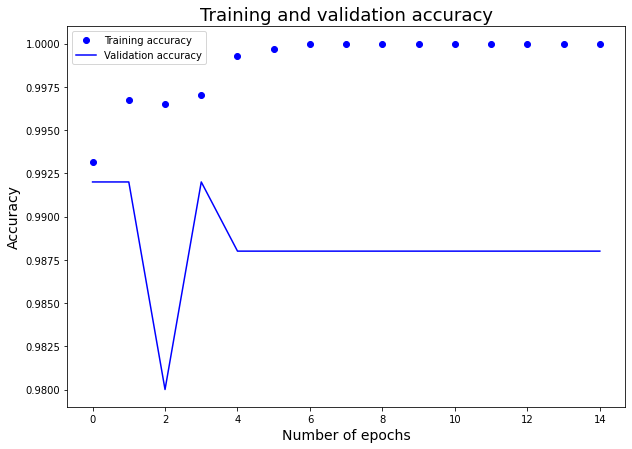

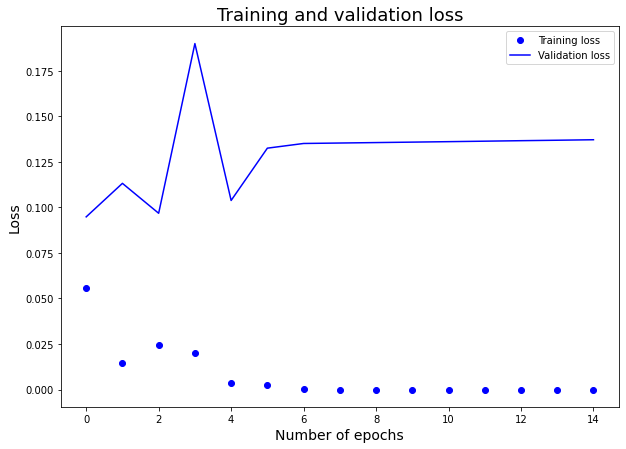

In [ ]:
run_model(**params)